In [1]:
import os
import pycolmap
from pathlib import Path
import numpy as np
from collections import defaultdict
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from hloc.utils.io import list_h5_names, get_matches, get_keypoints
from hloc.visualization import plot_images, plot_keypoints, plot_matches, read_image, add_text, cm_RdGn

In [2]:
DIR = "../image-matching-challenge-2023"
MODE = "train"
NAME = "SP+LG+sift+NN-rot"
dataset = "urban" # "heritage", "haiper", "urban"
scene = "kyiv-puppet-theater" # "dioscuri", "cyprus", "wall", "kyiv-puppet-theater", "bike", "chairs", "fountain"

In [3]:
scene_dir = Path(f"../outputs/{NAME}/{dataset}/{scene}")

images = Path(f"{DIR}/{MODE}/{dataset}/{scene}/images")

features = scene_dir / "features.h5"
matches = scene_dir / "matches.h5"

In [4]:
n_models = len(os.listdir(scene_dir / "sparse" / "models"))

print(f"Found {n_models} models")

Found 1 models


In [5]:
models = {}

for i in range(n_models):
    model_path = scene_dir / "sparse" / "models" / f"{i}"
    if i == 0:
        model_path = scene_dir / "sparse"
    try:
        rec = pycolmap.Reconstruction(model_path)
        reg_images = [img.name for img in rec.images.values()]
        models[i] = {
            "model": rec,
            "images": reg_images
        }
    except ValueError:
        print(f"Could not load model {i}")

all_registered = set().union(*[set(models[i]["images"]) for i in models])

In [6]:
print(models[0]['model'].summary())

Reconstruction:
	num_reg_images = 27
	num_cameras = 27
	num_points3D = 8371
	num_observations = 29497
	mean_track_length = 3.52371
	mean_observations_per_image = 1092.48
	mean_reprojection_error = 0.942224


In [7]:
image_names = sorted(list_h5_names(features))
pairs = sorted(list_h5_names(matches))

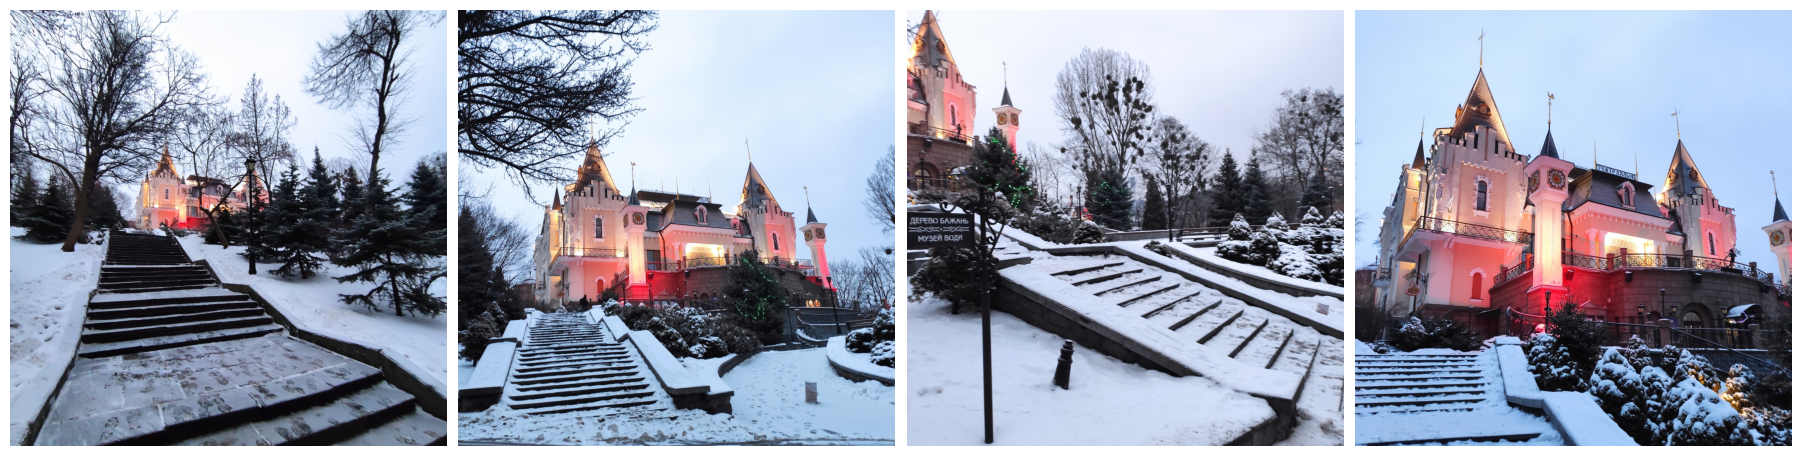

In [8]:
plot_images([read_image(images / imname) for imname in image_names[:4]])

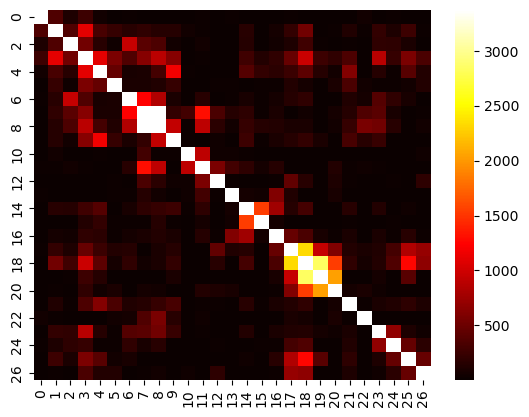

In [9]:
match_matrix = -np.ones([len(image_names), len(image_names)])
for pair in pairs:
    name0, name1 = pair.split("/")
    idx0, idx1 = image_names.index(name0), image_names.index(name1)
    m, sc = get_matches(matches, name0, name1)
    match_matrix[idx0, idx1] = match_matrix[idx1, idx0] = m.shape[0]

ax = sns.heatmap(match_matrix, linewidth=0.0, cmap="hot", mask=match_matrix < 0)

In [10]:
reg_images = [img for img in image_names if img in models[0]['images']]
unreg_images = [img for img in image_names if img not in reg_images]

match_matrix = -np.ones([len(unreg_images), len(reg_images)])
for pair in pairs:
    name0, name1 = pair.split("/")
    m, sc = get_matches(matches, name0, name1)

    if name0 in unreg_images and name1 in reg_images:
        idx0, idx1 = unreg_images.index(name0), reg_images.index(name1)
        match_matrix[idx0, idx1] = m.shape[0]

    elif name1 in unreg_images and name0 in reg_images:
        idx0, idx1 = unreg_images.index(name1), reg_images.index(name0)
        match_matrix[idx0, idx1] = m.shape[0]


ax = sns.heatmap(
    match_matrix, 
    linewidth=0.0, 
    cmap="hot",
    yticklabels=unreg_images,
    xticklabels=reg_images,
    mask=match_matrix < 0
)

ValueError: zero-size array to reduction operation fmin which has no identity

In [14]:
many_matches = np.where(match_matrix > 200)

for i, j in zip(*many_matches):
    name0, name1 = unreg_images[i], reg_images[j]
    fig = plot_images(
        [read_image(images / unreg_images[i]), read_image(images / reg_images[j])],
        titles=[unreg_images[i], reg_images[j]]
    )
    kp0, kp1 = get_keypoints(features, name0), get_keypoints(features, name1)
    m, sc = get_matches(matches, name0, name1)
    plot_matches(kp0[m[:,0]], kp1[m[:,1]], a=0.1)
    n_matches = m.shape[0]
    [add_text(k, f'matches: {n_matches}, reg: {name in models[0]["images"]}') for k, name in enumerate([name0, name1])];
    
    plt.show()

Text(0.5, 1.0, 'total number of matches per image')

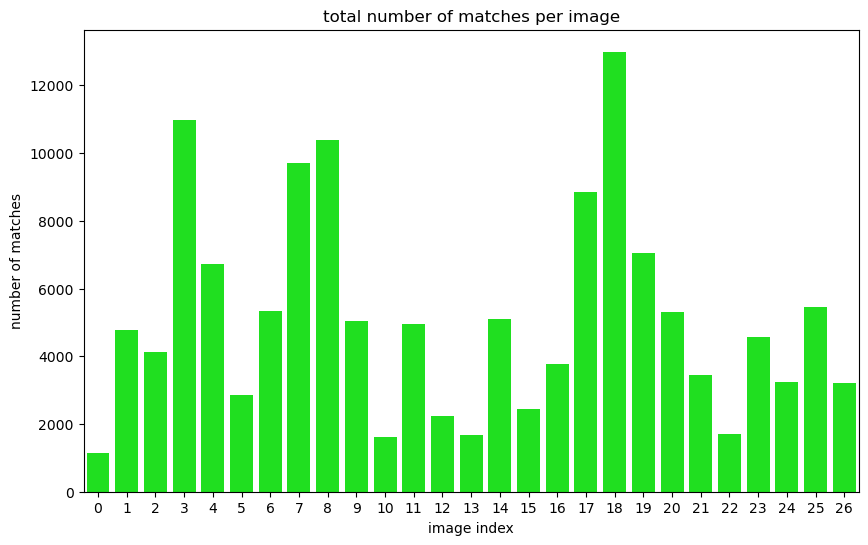

In [15]:
match_matrix = -np.ones([len(image_names), len(image_names)])
for pair in pairs:
    name0, name1 = pair.split("/")
    idx0, idx1 = image_names.index(name0), image_names.index(name1)
    m, sc = get_matches(matches, name0, name1)
    match_matrix[idx0, idx1] = match_matrix[idx1, idx0] = m.shape[0]
    
total = (match_matrix * (match_matrix > 0)).sum(-1)

# color by registered images green and unregistered images red

colors = np.array([1, 0, 0])[np.newaxis, :].repeat(len(image_names), axis=0)
for i, name in enumerate(image_names):
    if name in models[0]["images"]:
        colors[i] = np.array([0, 1, 0])
    elif name in all_registered:
        colors[i] = np.array([1, 1, 0])

fig, ax = plt.subplots(figsize=(10, 6))
ax = sns.barplot(x=list(range(len(image_names))), y=total, palette=colors)
ax.set_xlabel('image index')
ax.set_ylabel('number of matches')
ax.set_title('total number of matches per image')

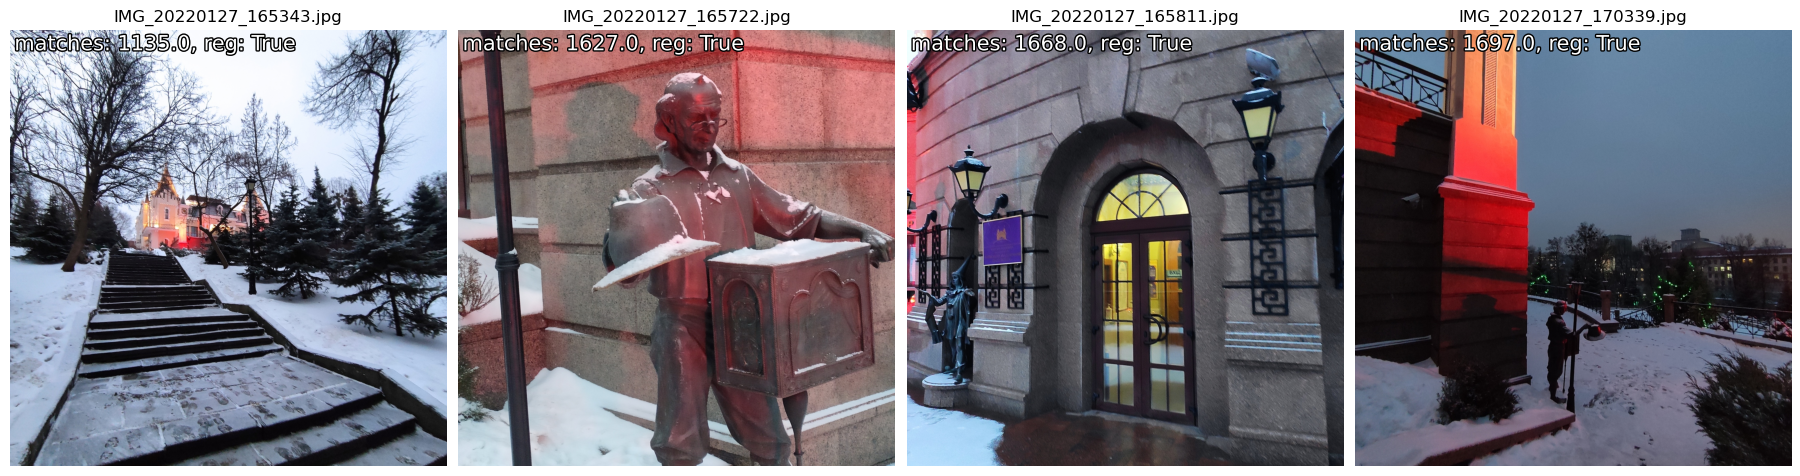

In [16]:
# 4 images with least amount of matches
ksmallest = np.argsort(total)[:4]
fig = plot_images([read_image(images / image_names[j]) for j in ksmallest], titles=[image_names[j] for j in ksmallest])
[add_text(i, f'matches: {total[j]}, reg: {image_names[j] in models[0]["images"]}') for i, j in enumerate(ksmallest)];

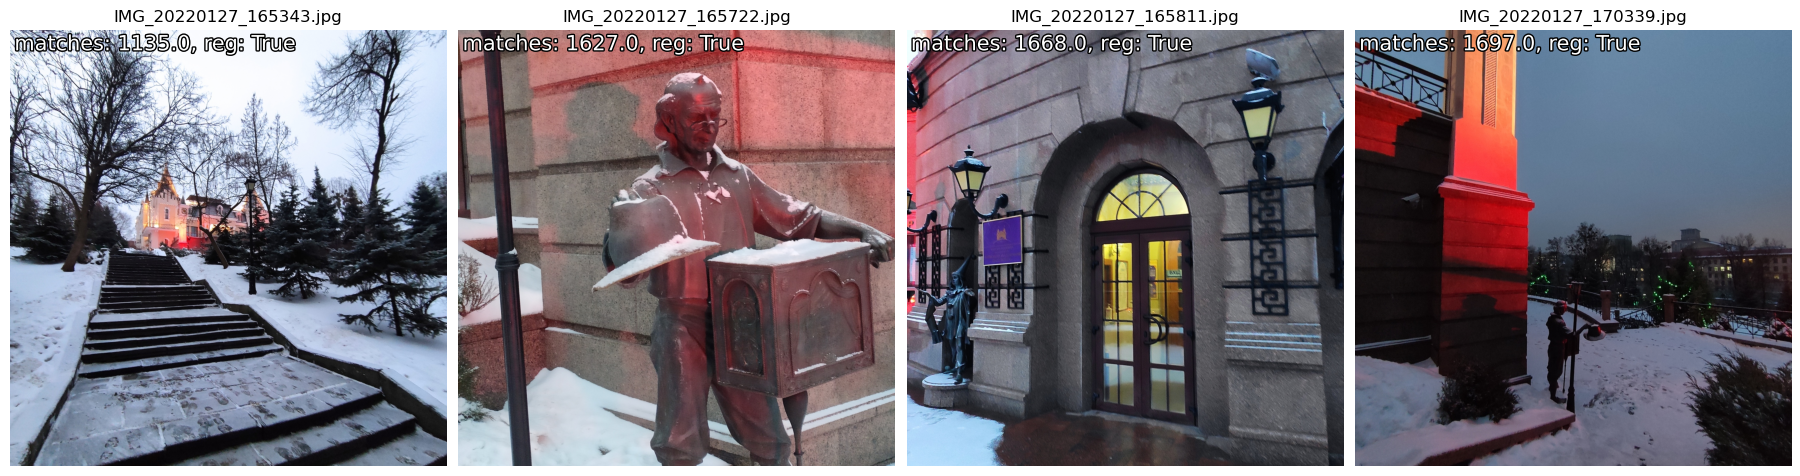

In [17]:
# 4 images with least amount of matches
ksmallest = np.argsort(total)[:4]
fig = plot_images([read_image(images / image_names[j]) for j in ksmallest], titles=[image_names[j] for j in ksmallest])
[add_text(i, f'matches: {total[j]}, reg: {image_names[j] in all_registered}') for i, j in enumerate(ksmallest)];

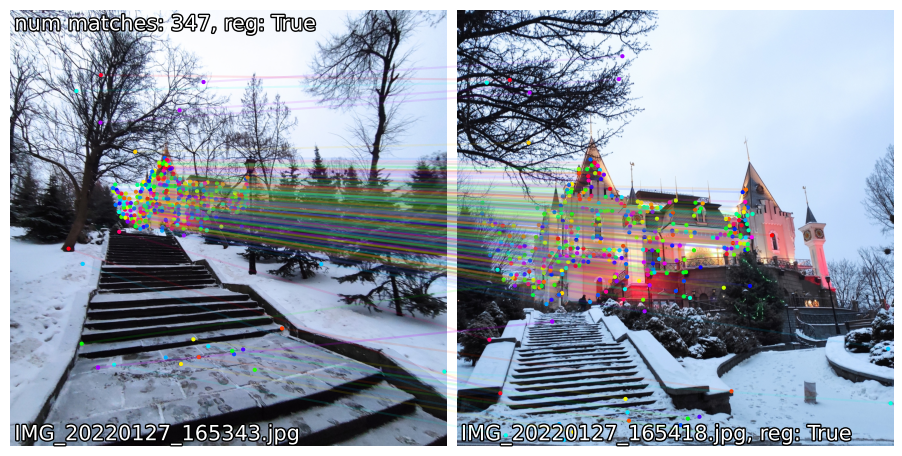

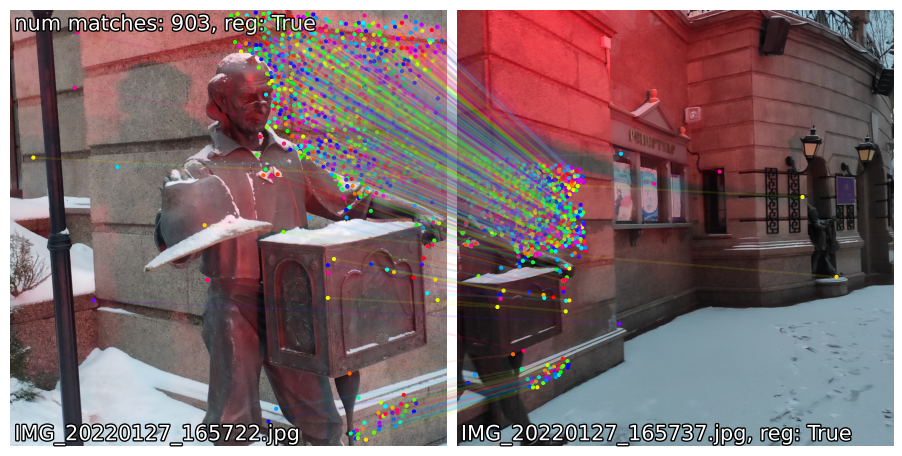

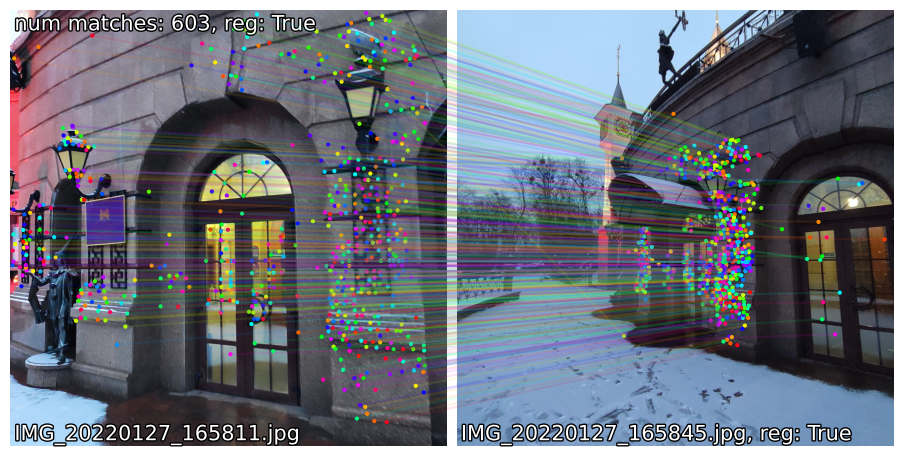

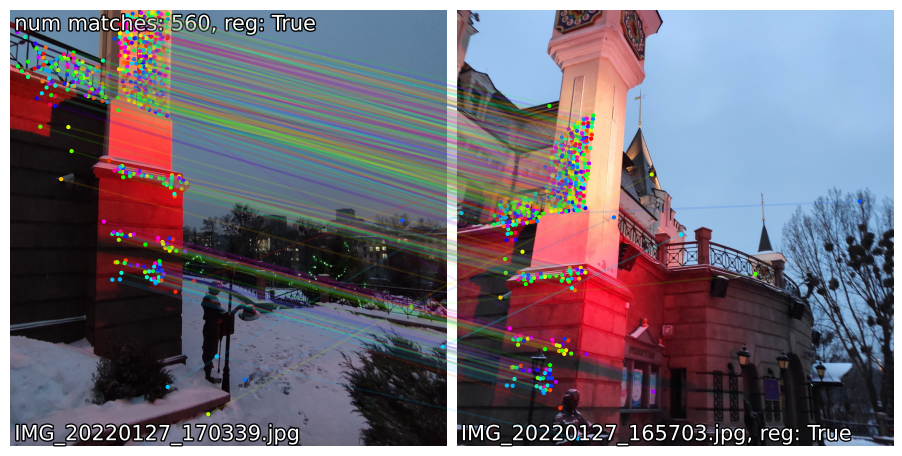

In [19]:
# print top-pair for each of above image
for j in ksmallest:
    name0 = image_names[j]
    name1 = image_names[np.argmax(match_matrix[j])]
    plot_images([read_image(images / name0), read_image(images / name1)])
    kp0, kp1 = get_keypoints(features, name0), get_keypoints(features, name1)
    m, sc = get_matches(matches, name0, name1)
    plot_matches(kp0[m[:,0]], kp1[m[:,1]], a=0.1)
    add_text(0, f'num matches: {m.shape[0]}, reg: {name0 in models[0]["images"]}')
    add_text(0, name0, pos=(0.01, 0.05))
    add_text(1, f'{name1}, reg: {name1 in models[0]["images"]}', pos=(0.01, 0.05))

In [13]:
# get unregeistered images with most matches
kmost = np.argsort(total)[::-1]
kmost = [k for k in kmost if image_names[k] not in models[0]["images"]]
kmost = kmost[:4]
fig = plot_images([read_image(images / image_names[j]) for j in kmost], titles=[image_names[j] for j in kmost])
[add_text(i, f'matches: {total[j]}, reg: {image_names[j] in models[0]["images"]}') for i, j in enumerate(kmost)]

NameError: name 'total' is not defined

In [ ]:
# get matches from unregeistered images to regeistered images
unreg = np.array([name for name in image_names if name not in models[0]["images"]])

match_counts_reg_unreg = np.zeros([len(models[0]["images"]), len(unreg)])

for i, name0 in enumerate(models[0]["images"]):
    for j, name1 in enumerate(unreg):
        try:
            m, sc = get_matches(matches, name0, name1)
        except ValueError:
            continue
        match_counts_reg_unreg[i, j] = m.shape[0]

In [ ]:
# get unregistered image with most matches to registered images
kmost = np.argsort(match_counts_reg_unreg.max(0))[::-1]

for j in kmost:
    name0 = unreg[j]
    name1 = reg_images[np.argmax(match_counts_reg_unreg[:, j])]

    if np.argmax(match_counts_reg_unreg[:, j]) == 0:
        continue

    plot_images([read_image(images / name0), read_image(images / name1)])
    kp0, kp1 = get_keypoints(features, name0), get_keypoints(features, name1)
    m, sc = get_matches(matches, name0, name1)
    plot_matches(kp0[m[:,0]], kp1[m[:,1]])
    add_text(0, f'num matches: {m.shape[0]}, reg: {name0 in models[0]["images"]}')
    add_text(0, name0, pos=(0.01, 0.05))
    add_text(1, f'{name1}, reg: {name1 in models[0]["images"]}', pos=(0.01, 0.05))

In [ ]:
# plot all unreigstered images
kunreg = np.where([name not in models[0]["images"] for name in image_names])[0]

rows = min(4, len(kunreg))

grid = (rows, len(kunreg) // rows + 1)

fig, ax = plt.subplots(grid[0], grid[1], figsize=(grid[1] * 4, grid[0] * 4))

ax = ax.flatten()

for i, j in enumerate(kunreg):
    ax[i].imshow(read_image(images / image_names[j]))
    ax[i].set_title(f"{image_names[j]}, matches: {total[j]}")
    ax[i].axis("off")

plt.suptitle(f"unregistered images in {scene}: {len(kunreg)}")
plt.show()

In [ ]:
# plot all unreigstered images (rotated)
kunreg = np.where([name not in models[0]["images"] for name in image_names])[0]

rows = min(4, len(kunreg))

grid = (rows, len(kunreg) // rows + 1)

fig, ax = plt.subplots(grid[0], grid[1], figsize=(grid[1] * 4, grid[0] * 4))

ax = ax.flatten()

rotated_images = scene_dir / "images_rotated"

for i, j in enumerate(kunreg):

    ax[i].imshow(read_image(rotated_images / image_names[j]))
    ax[i].set_title(f"{image_names[j]}, matches: {total[j]}")
    ax[i].axis("off")

plt.suptitle(f"unregistered (rotated) images in {scene}: {len(kunreg)}")
plt.show()

In [ ]:
for idx, data in models.items():
    print(f"Model{idx}: {data['model'].summary()}\n")

In [ ]:
for idx, data in models.items():
    if idx == 0:
        continue

    print(f"Model{idx}: number of registered images: {len(data['images'])}")
    # plot registered images
    reg = [read_image(images / name) for name in data["images"]]
    fig = plot_images(reg, titles=data["images"])
    [add_text(i, f'reg: {name in models[0]["images"]}') for i, name in enumerate(data["images"])]
    plt.show()